# Objectives: 
## - Develop a predictive (regression) model that predicts prices of (future) iPhone releases
## - Train the model with data of iPhone prices from first release (2007) to present day
## - Deploy predictive model into the front-end as a web application using Dash (Python) and/or React (JavaScript) 


In [2]:
## IMPORTS AND SETUP

# Core Python imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import seaborn as sns 
%matplotlib inline 

# setup of DataFrame and save function 
data_path = "./iphone_releases.csv"

iphones = pd.read_csv(data_path)

def saveOutput(df, filename):
    df.to_csv(filename)

### Stage 1: Pre-Processing
#### - Clean, format, and repurpose iPhone price data for the predictive model

In [3]:
## DATA CLEANING AND REFORMATTING 

# CONVERT ALL TO LOWERCASE 
# turn rows to uppercase 
iphones = iphones.apply(lambda col: col.str.upper() if 'O' == col.dtype  else col) 
# turn columns to uppercase 
iphones.columns = iphones.columns.str.upper() 

# REFORMAT "DATE" COLUMN 
# exclude month and day, only keep year 
iphones["DATE"] = iphones["DATE"].str[:4] 

# RENAME COLUMNS 
# rename "date" column to "year" 
iphones.rename(columns={"DATE": "YEAR"}, inplace=True) 
# cast "YEAR" column as int 
iphones["YEAR"] = iphones["YEAR"].astype(int) 
# rename "memory" column to "GB" 
iphones.rename(columns={"MEMORY": "GB"}, inplace=True) 

# FILL MISSING VALUES 
# set the "version" of the first 2 rows (original iPhone) as "1" 
iphones.loc[2007 == iphones["YEAR"] , "VERSION"] = 1 

# set missing "edition" values to 0, for iPhones not of special edition 
edition_regular = "STANDARD" 
iphones.loc[iphones["EDITION"].isnull(), "EDITION"] = edition_regular 

# set missing "scale" values to "STANDARD", for iPhones not of special size 
size_regular = "MEDIUM" 
iphones.loc[iphones["SCALE"].isnull(), "SCALE"] = size_regular 

# RE-FORMAT SIMILAR (REDUNDANT) VALUE TYPES 
# reformat "edition" column, merge "S" and "PRO" values 
edition_special = "SPECIAL" 
iphones.loc[('S' == iphones["EDITION"]) | ("PRO" == iphones["EDITION"]), "EDITION"] = edition_special 

# reformat "scale" column, merge "Plus" and "Max" values 
size_large = "LARGE" 
iphones.loc[("PLUS" == iphones["SCALE"]) | ("MAX" == iphones["SCALE"]), "SCALE"] = size_large 

# REMOVE OUTLIERS / EXCEPTIONAL DATA POINTS 
# drop samples with "edition" values other than "SPECIAL" or "STANDARD" (like "R" or "C") 
iphones = iphones.loc[~((iphones["EDITION"] != edition_regular) & (iphones["EDITION"] != edition_special))] 

# RENAME VERSIONS TO NUMERICAL VALUES (like 3G -> 3, X -> 10) 
iphones.loc["3G" == iphones["VERSION"], "VERSION"] = 3 
iphones.loc['X' == iphones["VERSION"], "VERSION"] = 10 
iphones["VERSION"] = iphones["VERSION"].astype(int) 

# drop samples with "edition" values other than "NORMAL" or "LARGE" (like "MINI") 
iphones = iphones.loc[~((iphones["SCALE"] != size_regular) & (iphones["SCALE"] != size_large))] 

# drop releases from 2007 due to unusual prices 
iphones = iphones.loc[~(2007 == iphones["YEAR"])] 

In [4]:
# REMOVING IPHONE X RELEASES FROM 2017 
# TWO VERSIONS OF THE IPHONE X (10) WERE RELEASED IN THE SAME YEAR AS THE IPHONE 8 
# AS A RESULT, THE YEAR 2017 HAS A VERY WIDE RANGE OF PRICES, SINCE MULTIPLE VERSIONS WERE RELEASED 
# THIS WILL SURELY DISTORT THE DATA AND WORSEN THE QUALITY OF THE PREDICTIONS 

iphones = iphones.loc[~((10 == iphones["VERSION"]) & (2017 == iphones["YEAR"]))] 

In [5]:
## DATA ENGINEERING (REPURPOSING) 

# convert "EDITION" to binary feature (via casting) 
iphones.loc[:, "EDITION"] = (edition_special == iphones["EDITION"]).astype(int) 
# rename "EDITION" column  to "SPECIAL" 
iphones.rename(columns={"EDITION": "SPECIAL"}, inplace=True) 

# convert "SCALE" to binary feature (via casting) 
iphones.loc[:, "SCALE"] = (size_large == iphones["SCALE"]).astype(int) 
# rename "SCALE" column to "LARGE" 
iphones.rename(columns={"SCALE": "LARGE"}, inplace=True) 

### Stage 2: EDA (Exploratory Data Analysis) 

<Axes: title={'center': 'iPhone prices by year'}, xlabel='YEAR', ylabel='PRICE'>

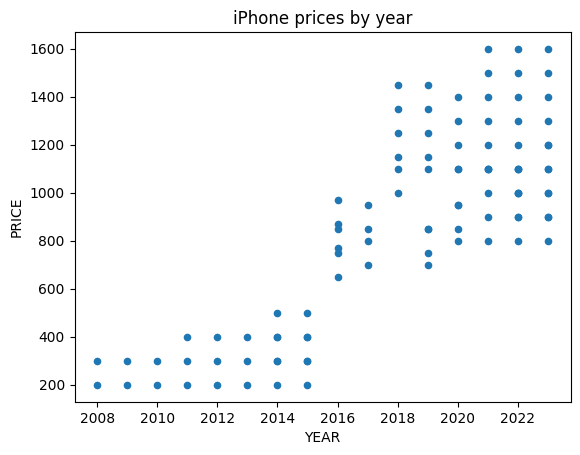

In [6]:
## DATA VISUALIZATION OF PRICES BY YEAR 
iphones.plot(kind="scatter", x="YEAR", y="PRICE", title="iPhone prices by year") 

# WE OBSERVE THAT PRICES HAVE A POSITIVE CORRELATION TO THE YEAR 

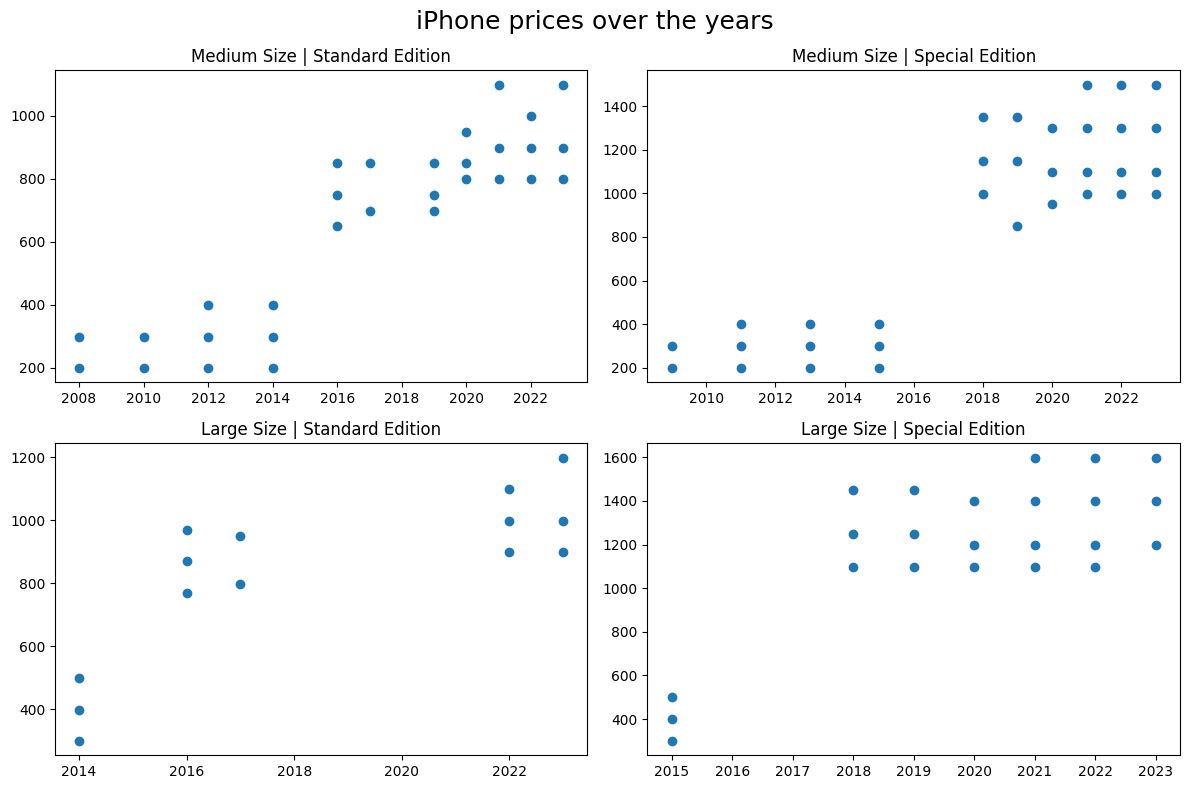

In [7]:
## DATA VISUALIZATION OF PRICES BY CATEGORY 

# PLOT AVERAGE PRICES OF IPHONE EDITIONS OVER THE YEARS 
# DIVIDE INTO CATEGORIES OF SIZE AND EDITION 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8)) 
fig.suptitle("iPhone prices over the years", size=18) 

# plot medium-sized, standard edition iPhones 
axes[0,0].set_title("Medium Size | Standard Edition") 
phones_med_std = iphones.loc[(0 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])] 
axes[0,0].scatter(phones_med_std["YEAR"], phones_med_std["PRICE"])

# plot medium-sized, special edition iPhones 
axes[0,1].set_title("Medium Size | Special Edition") 
phones_med_spec = iphones.loc[(0 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[0,1].scatter(phones_med_spec["YEAR"], phones_med_spec["PRICE"]) 

# plot large-sized, standard edition iPhones 
axes[1,0].set_title("Large Size | Standard Edition") 
phones_lg_std = iphones.loc[(1 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])]
axes[1,0].scatter(phones_lg_std["YEAR"], phones_lg_std["PRICE"])

# plot large-sized, special edition iPhones 
axes[1,1].set_title("Large Size | Special Edition") 
phones_lg_spec = iphones.loc[(1 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[1,1].scatter(phones_lg_spec["YEAR"], phones_lg_spec["PRICE"]) 

fig.tight_layout() 

# WE OBSERVE A SIGNIFICANT PRICE INCREASE IN ALL CATEGORIES BETWEEN 2016 AND 2018 

<Axes: title={'center': 'iPhone storage capacities by year'}, xlabel='YEAR', ylabel='GB'>

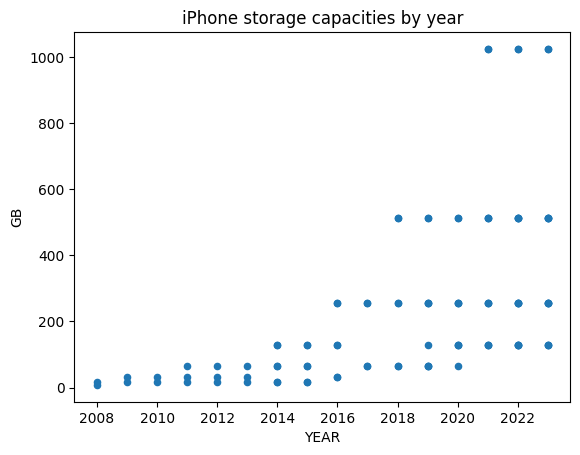

In [8]:
## DATA VISUALIZATION OF STORAGE CAPACITY BY YEAR 

iphones.plot("YEAR", "GB", kind="scatter", title="iPhone storage capacities by year") 

# WE OBSERVE: AS TIME ELAPSES, STORAGE CAPACITIES INCREASE 
# THERE SEEMS TO BE AN EXPONENTIAL (NON-LINEAR) RELATIONSHIP BETWEEN THESE TWO FEATURES 

<Axes: title={'center': 'iPhone prices by storage capacity'}, xlabel='GB', ylabel='PRICE'>

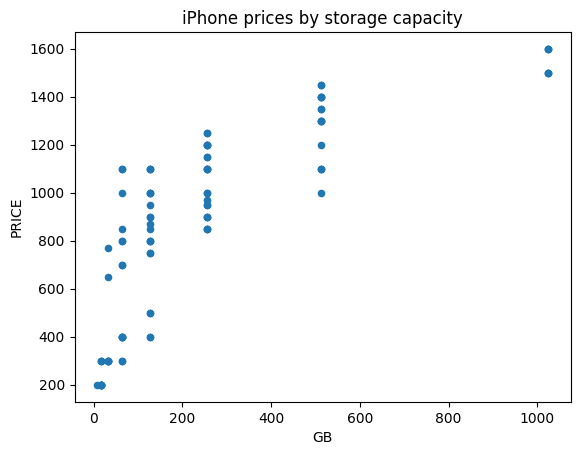

In [9]:
## DATA VISUALIZATION OF PRICES BY STORAGE CAPACITY 
iphones.plot(kind="scatter", x="GB", y="PRICE", title="iPhone prices by storage capacity") 

# WE OBSERVE A POSITIVE CORRELATION BETWEEN STORAGE CAPACITY AND PRICE 
# AS STORAGE CAPACITY INCREASES, SO DOES PRICE

<Axes: title={'center': 'iPhone prices by version'}, xlabel='VERSION', ylabel='PRICE'>

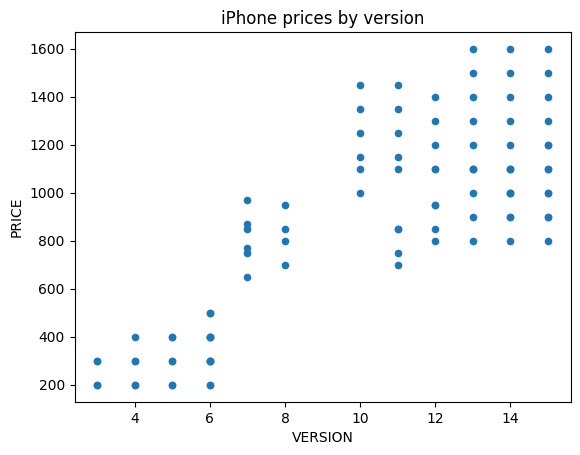

In [10]:
## DATA VISUALIZATION OF PRICES BY VERSION 
iphones.plot(kind="scatter", x="VERSION", y="PRICE", title="iPhone prices by version") 

# WE OBSERVE: AS VERSION NUMBER INCREASES, SO DOES PRICE 
# POSITIVE CORRELATION

<Axes: title={'center': 'iPhone versions by year'}, xlabel='YEAR', ylabel='VERSION'>

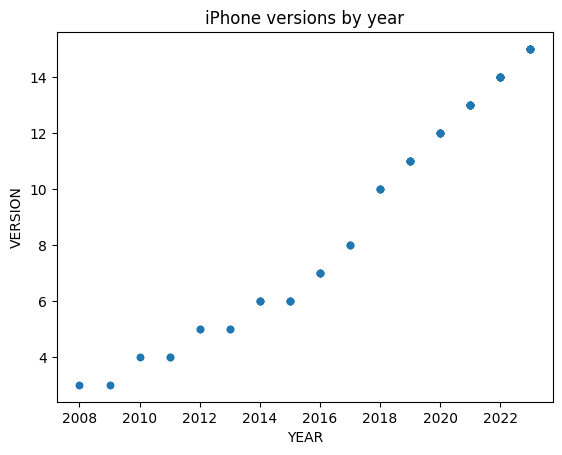

In [11]:
## DATA VISUALIZATION OF YEAR, BY VERSION 
iphones.plot(kind="scatter", x="YEAR", y="VERSION", title="iPhone versions by year") 

# WE OBSERVE HIGH COLLINEARITY BETWEEN "VERSION" AND "YEAR" (OBVIOUSLY) 
# THIS MEANS THAT WE SHOULD NOT USE THEM TOGETHER FOR MODELING / TRAINING 
# "VERSION" WILL BE OMITTED FROM TRAINING, SINCE "YEAR" WILL BE A USER INPUT AND "VERSION" CANNOT BE PREDICTED BY THE USER 

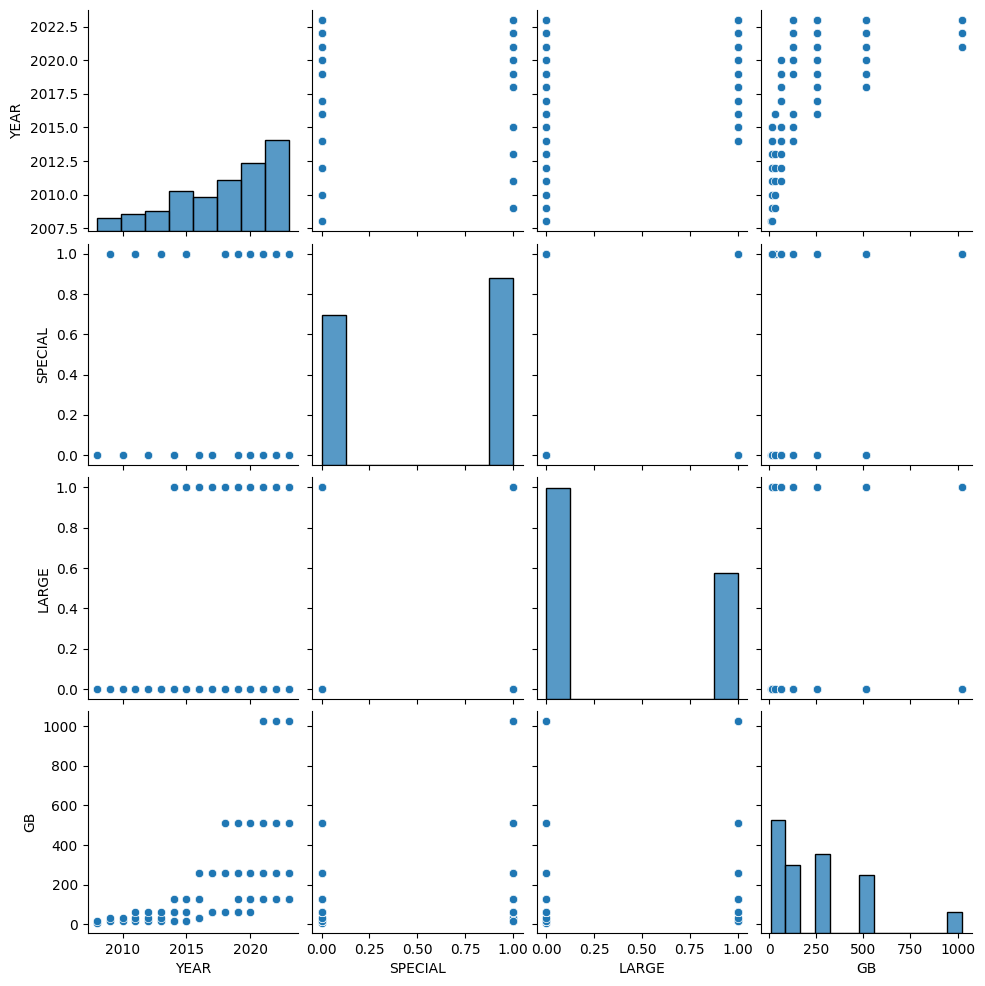

In [12]:
## DATA VISUALIZATION OF ALL FEATURES (EXCLUDING "VERSION" AND "PRICE") 
# WE ALREADY EXAMINED "PRICE" WITH OTHER FEATURES 

sns.pairplot(iphones.drop(["VERSION", "PRICE"], axis=1)) 

# WE OBSERVE A NOTABLE POSITIVE CORRELATION BETWEEN GB AND YEAR 
# however, this is not as much the year determining the storage, as much as technological availability 

In [13]:
# DROPPING "VERSION" FEATURE DUE TO HIGH COLLINEARITY WITH "YEAR"
# ALSO, THE USER SHOULDN'T HAVE TO INPUT THE VERSION NUMBER OF A FUTURE IPHONE, SINCE THEY DON'T KNOW IT 

iphones.drop("VERSION", axis=1, inplace=True)

### Step 3: Model Building 

#### Linear Regression

In [14]:
# Scikit-Learn imports 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

# Scikit-learn metrics 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
from sklearn.metrics import explained_variance_score 
from sklearn.model_selection import cross_validate 
from sklearn.linear_model import Lasso 

In [15]:
## MAKE DUMMIES OF STORAGE VALUES 
# BASE CASE: 8GB 

storage_dummies = pd.get_dummies(iphones["GB"], prefix="GB", drop_first=True) 

iphones_linreg = iphones.copy()

iphones_linreg = pd.concat( 
    [
        iphones_linreg, 
        storage_dummies.astype(int) 
    ], 
    axis = 1 
) 

# drop "GB" column 
iphones_linreg.drop("GB", axis=1, inplace=True) 

iphones_linreg = iphones_linreg.loc[iphones_linreg["YEAR"] >= 2016] 

In [16]:
## PROCESSING AND TRAINING 

# SPLIT DATASET FOR TRAINING AND TESTING 
numerical_features_linreg = ["YEAR"] 
binary_features_linreg = ["SPECIAL", "LARGE"] + [gb_size for gb_size in storage_dummies.columns] 

X_linreg = iphones_linreg[numerical_features_linreg + binary_features_linreg]
y_linreg = iphones_linreg["PRICE"] 

X_linreg_train, X_linreg_test, y_linreg_train, y_linreg_test = train_test_split(X_linreg, y_linreg, 
                                                    test_size = 0.2, 
                                                    random_state = 202 
                                                    ) 

# STANDARDIZE DATASET'S NUMERICAL FEATURES (ONLY YEAR, IN THIS CASE) 
scaler = StandardScaler() 
scaler.fit(X_linreg_train[numerical_features_linreg]) 
X_linreg_train[numerical_features_linreg] = scaler.fit_transform(X_linreg_train[numerical_features_linreg]) 
X_linreg_test[numerical_features_linreg] = scaler.fit_transform(X_linreg_test[numerical_features_linreg]) 

# TRAIN LINEAR REGRESSION MODEL WITH NEW DATASET 

linreg = LinearRegression() 
linreg.fit(X_linreg_train, y_linreg_train) 
y_linreg_pred = linreg.predict(X_linreg_test) 

#### Linear Regression Evaluation 

,TRUE,PRED,ERR_VAL,ERR_PERCENT
61,799.0,697.361205,-101.638795,12.720750
63,949.0,872.047667,-76.952333,8.108781
46,1099.0,1046.296035,-52.703965,4.795629
101,799.0,765.561547,-33.438453,4.185038
103,1099.0,1059.718502,-39.281498,3.574295
33,849.0,878.737683,29.737683,3.502672
77,899.0,870.375163,-28.624837,3.184075
104,899.0,870.861698,-28.138302,3.129956
44,1149.0,1115.682346,-33.317654,2.899709
106,1199.0,1165.018653,-33.981347,2.834141


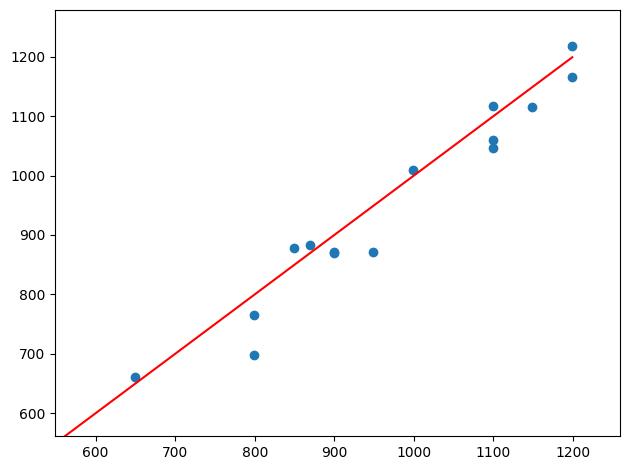

In [17]:
# DISPLAY ERRORS AND PERCENTAGE OF MODEL 

linreg_results = pd.DataFrame({ 
    "TRUE": y_linreg_test, 
    "PRED": y_linreg_pred, 
    "ERR_VAL": (y_linreg_pred - y_linreg_test) 
}) 

# ADD COLUMN OF PERCENTAGE OF ERROR FROM THE TRUE VALUE 
linreg_results["ERR_PERCENT"] = 100 * (linreg_results["ERR_VAL"] / linreg_results["TRUE"]).abs() 

fig, ax = plt.subplots() 
ax.scatter(x=linreg_results["TRUE"], y=linreg_results["PRED"]) 
ax.plot([0, linreg_results["TRUE"].max()], [0, linreg_results["TRUE"].max()], color="red") 
ax.set_xticks(range(0, int(max(linreg_results["PRED"])), 100)) 
ax.set_yticks(range(0, int(max(linreg_results["PRED"])),100)) 
ax.set_xlim(left=linreg_results["TRUE"].min() - 100) 
ax.set_ylim(bottom=linreg_results["PRED"].min() - 100)
fig.tight_layout() 

linreg_results.sort_values(by="ERR_PERCENT", ascending=False) 

In [24]:
cvfolds_linreg = 31 
# THRESHOLD AT 24 
# LOWEST ERROR AT 31

metrics = pd.DataFrame(data={ 
    "FOLDS": cvfolds_linreg, 
    "MSE": cross_validate(linreg, X_linreg, y_linreg, scoring="neg_mean_squared_error", cv=cvfolds_linreg)["test_score"].mean() * -1,
    "MAE": cross_validate(linreg, X_linreg, y_linreg, scoring="neg_mean_absolute_error", cv=cvfolds_linreg)["test_score"].mean() * -1,
    "R2": cross_validate(linreg, X_linreg, y_linreg, scoring="r2", cv=cvfolds_linreg)["test_score"].mean(),
    "EV": cross_validate(linreg, X_linreg, y_linreg, scoring="explained_variance", cv=cvfolds_linreg)["test_score"].mean(), 
}, index=[linreg]) 

metrics 

,FOLDS,MSE,MAE,R2,EV
LinearRegression(),31,1221.213498,26.220637,0.794213,0.901738


#### Lasso Regression 

In [19]:
## LASSO REGRESSION 

# copy dataframe for Lasso 
iphones_lasso1 = iphones.copy() 

# set numerical and binary features for Lasso 
numerical_features_lasso1 = ["YEAR", "GB"] 
binary_features_lasso1 = ["SPECIAL", "LARGE"] 

X_lasso1 = iphones_lasso1[numerical_features_lasso1 + binary_features_lasso1] 
y_lasso1 = iphones_lasso1["PRICE"] 

# train-test split on lasso1 dataset 
X_lasso1_train, X_lasso1_test, y_lasso1_train, y_lasso1_test = train_test_split(X_lasso1, y_lasso1, 
                                                                            test_size = 9/99, 
                                                                            random_state = 1 
                                                                            )

# standardize numerical features of Lasso dataset 
scaler.fit(X_lasso1_train[numerical_features_lasso1]) 
X_lasso1_train[numerical_features_lasso1] = scaler.fit_transform(X_lasso1_train[numerical_features_lasso1]) 
X_lasso1_test[numerical_features_lasso1] = scaler.fit_transform(X_lasso1_test[numerical_features_lasso1]) 

# train lasso regression model 
lasso1reg = Lasso() 
lasso1reg.fit(X_lasso1_train, y_lasso1_train) 
y_lasso1_pred = lasso1reg.predict(X_lasso1_test)

# display weights of first lasso regression model
print(pd.Series(lasso1reg.coef_, index=X_lasso1_train.columns)) 

# prepare and display first lasso regression model's results 

lasso1reg_results = pd.DataFrame({
    "TRUE": y_lasso1_test, 
    "PRED": y_lasso1_pred, 
    "ERR_VAL": y_lasso1_pred - y_lasso1_test
}) 

lasso1reg_results["ERR_PERCENT"] = 100 * (lasso1reg_results["ERR_VAL"] / lasso1reg_results["TRUE"]).abs()

lasso1reg_results.sort_values(by="ERR_PERCENT", ascending=False) 

YEAR       217.370598
GB         176.629326
SPECIAL    124.959770
LARGE       89.051564
dtype: float64


,TRUE,PRED,ERR_VAL,ERR_PERCENT
36,969.0,524.080451,-444.919549,45.915330
21,399.0,222.917802,-176.082198,44.130877
39,799.0,473.691497,-325.308503,40.714456
95,1299.0,1118.099665,-180.900335,13.926123
98,1199.0,1050.706732,-148.293268,12.368079
93,999.0,883.432920,-115.567080,11.568276
107,999.0,950.377338,-48.622662,4.867133
96,1499.0,1430.988658,-68.011342,4.537114
103,1099.0,1060.084313,-38.915687,3.541009


In [52]:
## LASSO 1 METRICS 

cvfolds_lasso1 = 31

metrics.loc["Lasso 1", "FOLDS"] = cvfolds_lasso1
metrics.loc["Lasso 1", "MSE"] = cross_validate(lasso1reg, X_lasso1, y_lasso1, scoring="neg_mean_squared_error", cv=cvfolds_lasso1)["test_score"].mean() * -1 
metrics.loc["Lasso 1", "MAE"] = cross_validate(lasso1reg, X_lasso1, y_lasso1, scoring="neg_mean_absolute_error", cv=cvfolds_lasso1)["test_score"].mean() * -1 
metrics.loc["Lasso 1", "R2"] = cross_validate(lasso1reg, X_lasso1, y_lasso1, scoring="r2", cv=cvfolds_lasso1)["test_score"].mean() 
metrics.loc["Lasso 1", "EV"] = cross_validate(lasso1reg, X_lasso1, y_lasso1, scoring="explained_variance", cv=cvfolds_lasso1)["test_score"].mean() 

metrics 

# WE OBSERVE THAT STANDARD LASSO REGRESSION IS NOWHERE NEAR AS POWERFUL AS LINEAR REGRESSION (WITH GB DUMMIES) 

,FOLDS,MSE,MAE,R2,EV
LinearRegression(),31.0,1221.213498,26.220637,0.794213,0.901738
Lasso 1,31.0,27102.344106,133.632718,-2.607614,0.500571


In [85]:
# LASSO 2: WITH GB DUMMIES 

iphones_lasso2 = iphones.copy() 

iphones_lasso2 = pd.concat( 
    [iphones_lasso2, storage_dummies.astype(int)], 
    axis=1 
) 

iphones_lasso2.drop("GB", axis=1, inplace=True) 

,YEAR,SPECIAL,LARGE,PRICE,GB_16,GB_32,GB_64,GB_128,GB_256,GB_512,GB_1024
2,2008,0,0,199.0,0,0,0,0,0,0,0
3,2008,0,0,299.0,1,0,0,0,0,0,0
4,2009,1,0,199.0,1,0,0,0,0,0,0
5,2009,1,0,299.0,0,1,0,0,0,0,0
6,2010,0,0,199.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
109,2023,1,0,1299.0,0,0,0,0,0,1,0
110,2023,1,0,1499.0,0,0,0,0,0,0,1
111,2023,1,1,1199.0,0,0,0,0,1,0,0
112,2023,1,1,1399.0,0,0,0,0,0,1,0


In [21]:
saveOutput(iphones, "iphones_output.csv") 
saveOutput(iphones_linreg, "iphones_linreg_output.csv") 
saveOutput(iphones_lasso1, "iphones_lasso1.csv")

iphones_lasso1

,YEAR,SPECIAL,LARGE,GB,PRICE
2,2008,0,0,8,199.0
3,2008,0,0,16,299.0
4,2009,1,0,16,199.0
5,2009,1,0,32,299.0
6,2010,0,0,16,199.0
...,...,...,...,...,...
109,2023,1,0,512,1299.0
110,2023,1,0,1024,1499.0
111,2023,1,1,256,1199.0
112,2023,1,1,512,1399.0
